In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10


# Implementation of CNN Vanilla and CNN Resnet



### Defining CNN-Vanilla

In [3]:
import torch  # Import PyTorch library
import torch.nn as nn  # Import nn module for defining neural network layers

class VanillaBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(VanillaBlock, self).__init__()
        # Define first convolutional layer with batch normalization and ReLU activation
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch normalization
        self.relu = nn.ReLU(inplace=True)  # ReLU activation
        # Define second convolutional layer with batch normalization and ReLU activation
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch normalization
        self.stride = stride  # Store stride value for later use

    def forward(self, x):
        # Forward pass through the block
        out = self.relu(self.bn1(self.conv1(x)))  # Apply first convolution, batch normalization, and ReLU
        out = self.bn2(self.conv2(out))  # Apply second convolution and batch normalization
        out = self.relu(out)  # Apply ReLU
        return out  # Return output

class CNNVanilla(nn.Module):
    def __init__(self):
        super(CNNVanilla, self).__init__()
        # Define initial convolutional layer
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        # Define three VanillaBlocks
        self.vanilla_block1 = VanillaBlock(32, 64)
        self.vanilla_block2 = VanillaBlock(64, 64)
        self.vanilla_block3 = VanillaBlock(64, 64)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer

    def forward(self, x):
        # Forward pass through the network
        x = self.pool(torch.relu(self.conv1(x)))  # Apply initial convolution, ReLU, and pooling
        x = self.vanilla_block1(x)  # Pass through first VanillaBlock
        x = self.vanilla_block2(x)  # Pass through second VanillaBlock
        x = self.vanilla_block3(x)  # Pass through third VanillaBlock
        x = self.pool(x)  # Pooling
        x = x.view(-1, 64 * 8 * 8)  # Reshape tensor - Flattening
        x = torch.relu(self.fc1(x))  # Apply ReLU to first fully connected layer
        x = self.fc2(x)  # Apply second fully connected layer
        return x  # Return output


### Defining CNN-Resnet

In [4]:
# Define the ResNet block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        # Define first convolutional layer with batch normalization and ReLU activation
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch normalization
        self.relu = nn.ReLU(inplace=True)  # ReLU activation
        # Define second convolutional layer with batch normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch normalization
        self.stride = stride  # Store stride value for later use

        # Define shortcut connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()  # Empty sequential module

    def forward(self, x):
        residual = x  # Store input as residual
        out = self.relu(self.bn1(self.conv1(x)))  # Apply first convolution, batch normalization, and ReLU
        out = self.bn2(self.conv2(out))  # Apply second convolution and batch normalization
        out += self.shortcut(residual)  # Add shortcut connection
        out = self.relu(out)  # Apply ReLU
        return out  # Return output

class CNNResNet(nn.Module):
    def __init__(self):
        super(CNNResNet, self).__init__()
        # Define initial convolutional layer
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        # Define three ResNetBlocks
        self.resnet_block1 = ResNetBlock(32, 64)
        self.resnet_block2 = ResNetBlock(64, 64)
        self.resnet_block3 = ResNetBlock(64, 64)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer

    def forward(self, x):
        # Forward pass through the network
        x = self.pool(torch.relu(self.conv1(x)))  # Apply initial convolution, ReLU, and pooling
        x = self.resnet_block1(x)  # Pass through first ResNetBlock
        x = self.resnet_block2(x)  # Pass through second ResNetBlock
        x = self.resnet_block3(x)  # Pass through third ResNetBlock
        x = self.pool(x)  # Pooling
        x = x.view(-1, 64 * 8 * 8)  # Reshape tensor
        x = torch.relu(self.fc1(x))  # Apply ReLU to first fully connected layer
        x = self.fc2(x)  # Apply second fully connected layer
        return x  # Return output


### Loading CIFAR10 training and test data
Obtaining better result by taking mean and std values on data loaded instead of using mean and std from cnn tutorial.

100%|██████████| 170498071/170498071 [00:17<00:00, 9724862.39it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Shape of the first image in train set: torch.Size([3, 32, 32])
Shape of the first image in test set: torch.Size([3, 32, 32])
Sample images from the train set:


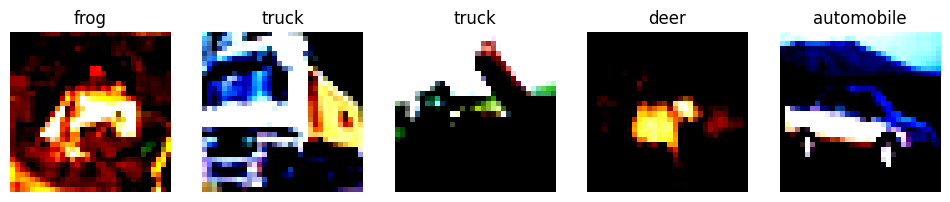

In [5]:
import torchvision.transforms as transforms  # Import transforms module from torchvision for data transformations
from torchvision.datasets import CIFAR10  # Import CIFAR10 dataset from torchvision.datasets
from torch.utils.data import DataLoader  # Import DataLoader for batch loading of data
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting
import numpy as np  # Import numpy for numerical operations

## mean = [0.4914, 0.4822, 0.4465] 
## std = [0.2470, 0.2435, 0.2616]
## The above mean values are given in CNN Tutorial

# Will give mean and standard deviation values by calculating based on loaded data (better performance)

# Define data augmentation and normalization transformations
transform_mean = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
])


# Define CIFAR-10 train and test datasets with the specified transformations
trainset_mean = CIFAR10(root='./data', train=True, download=True, transform=transform_mean)
#testset_mean = CIFAR10(root='./data', train=False, download=True, transform=transform_mean)


# Compute mean and standard deviation for each channel
mean = torch.stack([t.mean(dim=(1, 2)) for t, _ in trainset_mean]).mean(dim=0)
std = torch.stack([t.std(dim=(1, 2)) for t, _ in trainset_mean]).mean(dim=0)

# Define data augmentation and normalization transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean, std)  # Normalize the image
])

# Define CIFAR-10 train and test datasets with the specified transformations
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)


# Function to display sample images from the dataset
def show_samples(dataset, num_samples=5):
    classes = dataset.classes
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
    for i in range(num_samples):
        image, label = dataset[i]
        axes[i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
        axes[i].set_title(classes[label])
        axes[i].axis('off')
    plt.show()

# Print the shape of the first image in the train set
print("Shape of the first image in train set:", trainset[0][0].shape)

# Print the shape of the first image in the test set
print("Shape of the first image in test set:", testset[0][0].shape)

# Display sample images from the train set
print("Sample images from the train set:")
show_samples(trainset)

# Define data loaders
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)


### Initializing Models and printing model parameters
Loss Function chosen was CrossEntropyLoss and Optimizer chosen was Adam

In [6]:
# Create instances of CNNVanilla and CNNResNet models
cnn_vanilla = CNNVanilla()
cnn_resnet = CNNResNet()

# Print the architectures of the models
print(cnn_vanilla)
print(cnn_resnet)

# Set device to GPU if available, else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_vanilla.to(device)  # Move CNNVanilla model to device
cnn_resnet.to(device)  # Move CNNResNet model to device

# Print the number of parameters in each model
print("Number of parameters in CNN-Vanilla:", sum(p.numel() for p in cnn_vanilla.parameters()))
print("Number of parameters in CNN-ResNet:", sum(p.numel() for p in cnn_resnet.parameters()))

# Define loss function and optimizers for each model
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss function
optimizer_vanilla = optim.Adam(cnn_vanilla.parameters(), lr=0.001)  # Adam optimizer for CNNVanilla
optimizer_resnet = optim.Adam(cnn_resnet.parameters(), lr=0.001)  # Adam optimizer for CNNResNet

# Perform a forward pass through CNNResNet model with random input tensor
ans = cnn_resnet(torch.rand([256,3,32,32]).to(device))
print(ans.shape)  # Print the shape of the output tensor


CNNVanilla(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (vanilla_block1): VanillaBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (vanilla_block2): VanillaBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

### Defining function to train model

In [7]:
import torch 
import torch.nn as nn  
import torch.optim as optim  
import matplotlib.pyplot as plt  

# Function to train the model and compute accuracy
def train_model(model, trainloader, criterion, optimizer, num_epochs=50):
    model.train()  # Set the model to training mode
    train_accuracy_history = []  # List to store training accuracy for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0  # Initialize running loss
        correct_predictions = 0  # Initialize number of correct predictions
        total_predictions = 0  # Initialize total number of predictions
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)  # Get inputs and labels
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()  # Accumulate loss
            _, predicted = torch.max(outputs.data, 1)  # Get predicted labels
            total_predictions += labels.size(0)  # Increment total predictions
            correct_predictions += (predicted == labels).sum().item()  # Increment correct predictions

        # Calculate accuracy for the epoch
        epoch_accuracy = correct_predictions / total_predictions
        train_accuracy_history.append(epoch_accuracy)  # Append accuracy to history

        # Print epoch statistics
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}, Accuracy: {epoch_accuracy:.2%}')

    return train_accuracy_history  # Return training accuracy history


### Training CNN-Vanilla

In [8]:
# Train CNN-Vanilla
print("Training CNN-Vanilla:")
train_accuracy_vanilla = train_model(cnn_vanilla, trainloader, criterion, optimizer_vanilla)

Training CNN-Vanilla:
Epoch 1, Loss: 1.3967791634554765, Accuracy: 48.59%
Epoch 2, Loss: 0.9255734922326341, Accuracy: 67.14%
Epoch 3, Loss: 0.7507071574123538, Accuracy: 73.52%
Epoch 4, Loss: 0.6410457642406834, Accuracy: 77.48%
Epoch 5, Loss: 0.5640418952216908, Accuracy: 80.19%
Epoch 6, Loss: 0.5013592612682557, Accuracy: 82.51%
Epoch 7, Loss: 0.4422734895226907, Accuracy: 84.45%
Epoch 8, Loss: 0.3942275631184481, Accuracy: 86.02%
Epoch 9, Loss: 0.3460452482864565, Accuracy: 87.77%
Epoch 10, Loss: 0.30396854383300764, Accuracy: 89.26%
Epoch 11, Loss: 0.2699445175121025, Accuracy: 90.38%
Epoch 12, Loss: 0.2332033519918213, Accuracy: 91.70%
Epoch 13, Loss: 0.2044543601876619, Accuracy: 92.81%
Epoch 14, Loss: 0.16661799311333772, Accuracy: 94.12%
Epoch 15, Loss: 0.15087067689366487, Accuracy: 94.72%
Epoch 16, Loss: 0.12602734599946713, Accuracy: 95.50%
Epoch 17, Loss: 0.11089258184846566, Accuracy: 96.12%
Epoch 18, Loss: 0.10190541295296683, Accuracy: 96.40%
Epoch 19, Loss: 0.091331305

### Training CNN-Resnet

In [9]:
# Train CNN-ResNet
print("Training CNN-ResNet:")
train_accuracy_resnet = train_model(cnn_resnet, trainloader, criterion, optimizer_resnet)

Training CNN-ResNet:
Epoch 1, Loss: 1.716249517640289, Accuracy: 38.03%
Epoch 2, Loss: 1.0562654234925095, Accuracy: 62.20%
Epoch 3, Loss: 0.8135178517930362, Accuracy: 71.00%
Epoch 4, Loss: 0.6946366620915276, Accuracy: 75.52%
Epoch 5, Loss: 0.6113822673048291, Accuracy: 78.44%
Epoch 6, Loss: 0.5450797079473125, Accuracy: 80.72%
Epoch 7, Loss: 0.4948194086247561, Accuracy: 82.68%
Epoch 8, Loss: 0.4304427577524769, Accuracy: 84.86%
Epoch 9, Loss: 0.38999188752198705, Accuracy: 86.36%
Epoch 10, Loss: 0.3405202496416715, Accuracy: 88.02%
Epoch 11, Loss: 0.310495563763745, Accuracy: 89.09%
Epoch 12, Loss: 0.27222645244732196, Accuracy: 90.50%
Epoch 13, Loss: 0.23610865590827806, Accuracy: 91.74%
Epoch 14, Loss: 0.20821544771291772, Accuracy: 92.74%
Epoch 15, Loss: 0.17024721114002928, Accuracy: 94.10%
Epoch 16, Loss: 0.14333442940699812, Accuracy: 95.08%
Epoch 17, Loss: 0.1280945577107522, Accuracy: 95.52%
Epoch 18, Loss: 0.1094867550596899, Accuracy: 96.26%
Epoch 19, Loss: 0.098278250222

# Experiment 1

### Plotting Training accuracy vs Epochs of CNN-Resnet and CNN-Vanilla

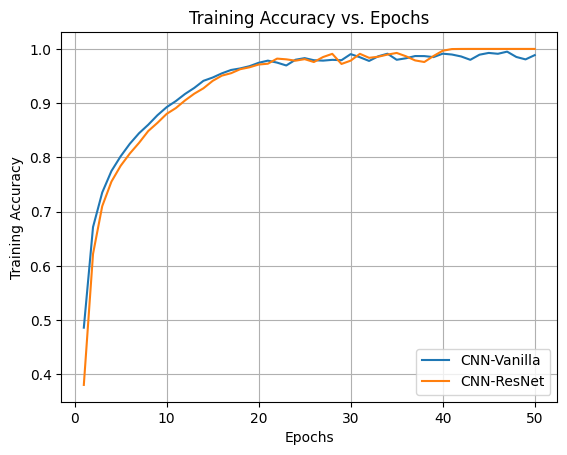

In [10]:
# Plotting training accuracy vs. epochs
plt.plot(range(1, len(train_accuracy_vanilla) + 1), train_accuracy_vanilla, label='CNN-Vanilla')
plt.plot(range(1, len(train_accuracy_resnet) + 1), train_accuracy_resnet, label='CNN-ResNet')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Evaluating Model Accuracy on Test Data

In [11]:
# Define function to evaluate model
def evaluate_model(model, testloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize number of correct predictions
    total = 0  # Initialize total number of predictions
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)  # Get images and labels
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            total += labels.size(0)  # Increment total predictions
            correct += (predicted == labels).sum().item()  # Increment correct predictions

    accuracy = 100 * correct / total  # Compute accuracy
    return accuracy  # Return accuracy

# Evaluate CNN-Vanilla
accuracy_vanilla = evaluate_model(cnn_vanilla, testloader)
print(f'Accuracy of CNN-Vanilla on the test set: {accuracy_vanilla:.2f}%')

# Evaluate CNN-ResNet
accuracy_resnet = evaluate_model(cnn_resnet, testloader)
print(f'Accuracy of CNN-ResNet on the test set: {accuracy_resnet:.2f}%')


Accuracy of CNN-Vanilla on the test set: 81.18%
Accuracy of CNN-ResNet on the test set: 83.44%


### Comparing number of Parameters and Performance

In [12]:
# Comparing number of parameters and performances
print("Number of parameters in CNN-Vanilla:", sum(p.numel() for p in cnn_vanilla.parameters()))
print("Number of parameters in CNN-ResNet:", sum(p.numel() for p in cnn_resnet.parameters()))

print(f'Accuracy of CNN-Vanilla on the test set: {accuracy_vanilla:.2f}%')
print(f'Accuracy of CNN-ResNet on the test set: {accuracy_resnet:.2f}%')

# Compare accuracies of CNN-Vanilla and CNN-ResNet
if accuracy_vanilla > accuracy_resnet:
    print("CNN-Vanilla performs better on the given problem.")
elif accuracy_vanilla < accuracy_resnet:
    print("CNN-ResNet performs better on the given problem.")
else:
    print("Both CNN-Vanilla and CNN-ResNet perform equally well on the given problem.")


Number of parameters in CNN-Vanilla: 730122
Number of parameters in CNN-ResNet: 732298
Accuracy of CNN-Vanilla on the test set: 81.18%
Accuracy of CNN-ResNet on the test set: 83.44%
CNN-ResNet performs better on the given problem.


## CNN-Resnet is the Winner !!
We will use CNN-Resnet for further analysis from here on

# Experiment 2 : Study the Effect of Data Normalization

### Loading Data without Normalization

Files already downloaded and verified
Files already downloaded and verified
Sample images from the train set:


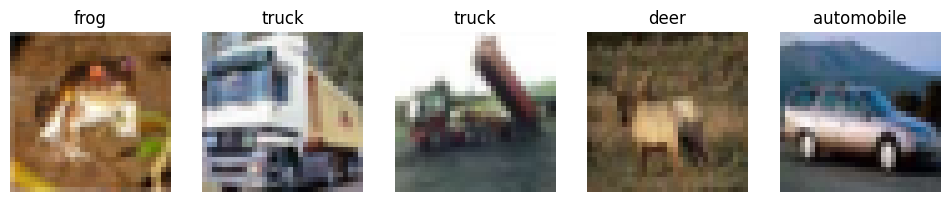

In [13]:
# Define normalization transformations
transform_without_norm = transforms.Compose([
    transforms.ToTensor() , # Convert PIL image to PyTorch tensor
])

# Define CIFAR-10 train and test datasets with the specified transformations
trainset_without_norm = CIFAR10(root='./data', train=True, download=True, transform=transform_without_norm )
testset_without_norm = CIFAR10(root='./data', train=False, download=True, transform=transform_without_norm )

# Display sample images from the train set
print("Sample images from the train set:")
show_samples(trainset_without_norm)

### Initializing and Training unnormalized model

In [14]:
# Create an instance of CNNResNet model without normalization
cnn_resnet_without_norm = CNNResNet()
cnn_resnet_without_norm.to(device)  # Move model to device

# Define optimizer for CNN-ResNet without normalization
optimizer_resnet_without_norm = optim.Adam(cnn_resnet_without_norm.parameters(), lr=0.001)

# Define data loaders for CNN-ResNet without normalization
trainloader_without_norm = DataLoader(trainset_without_norm, batch_size=256, shuffle=True)
testloader_without_norm = DataLoader(testset_without_norm, batch_size=256, shuffle=False)

# Train CNN-ResNet without data normalization
train_accuracy_resnet_unnormalized = train_model(cnn_resnet_without_norm, trainloader_without_norm, criterion, optimizer_resnet_without_norm)


Epoch 1, Loss: 1.7157695457643392, Accuracy: 39.36%
Epoch 2, Loss: 1.091723837110461, Accuracy: 60.73%
Epoch 3, Loss: 0.8653193602756578, Accuracy: 69.61%
Epoch 4, Loss: 0.7276378720998764, Accuracy: 74.28%
Epoch 5, Loss: 0.635449755252624, Accuracy: 77.74%
Epoch 6, Loss: 0.5555838235482877, Accuracy: 80.64%
Epoch 7, Loss: 0.5058531783977334, Accuracy: 82.23%
Epoch 8, Loss: 0.4495897499882445, Accuracy: 84.15%
Epoch 9, Loss: 0.4065931074473323, Accuracy: 85.75%
Epoch 10, Loss: 0.3545134026481181, Accuracy: 87.65%
Epoch 11, Loss: 0.31258584285268975, Accuracy: 89.02%
Epoch 12, Loss: 0.27706907377863416, Accuracy: 90.19%
Epoch 13, Loss: 0.24660410960109866, Accuracy: 91.27%
Epoch 14, Loss: 0.2145253999576885, Accuracy: 92.40%
Epoch 15, Loss: 0.19238868773895867, Accuracy: 93.21%
Epoch 16, Loss: 0.15675921342810806, Accuracy: 94.54%
Epoch 17, Loss: 0.13522299987320996, Accuracy: 95.28%
Epoch 18, Loss: 0.10999178658334577, Accuracy: 96.24%
Epoch 19, Loss: 0.10439735554082662, Accuracy: 96.

### Plotting Training accuracy vs Epochs for CNN-Resnet with and without normalization

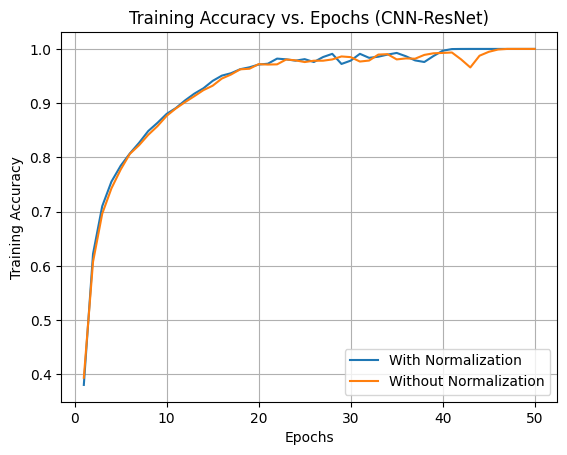

In [15]:
# Plotting training accuracy vs. epochs for both cases
plt.plot(range(1, len(train_accuracy_resnet) + 1), train_accuracy_resnet, label='With Normalization')
plt.plot(range(1, len(train_accuracy_resnet_unnormalized) + 1), train_accuracy_resnet_unnormalized, label='Without Normalization')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Epochs (CNN-ResNet)')
plt.legend()
plt.grid(True)
plt.show()

### Evaluating CNN-Resent accuracy on test data with and without Data Normalization

In [16]:
# Evaluate CNN-ResNet with data normalization
accuracy_resnet_normalized = evaluate_model(cnn_resnet, testloader)
print(f'Accuracy of CNN-ResNet with data normalization on the test set: {accuracy_resnet_normalized:.2f}%')

# Evaluate CNN-ResNet without data normalization
accuracy_resnet_unnormalized = evaluate_model(cnn_resnet_without_norm, testloader_without_norm)
print(f'Accuracy of CNN-ResNet without data normalization on the test set: {accuracy_resnet_unnormalized:.2f}%')

Accuracy of CNN-ResNet with data normalization on the test set: 83.44%
Accuracy of CNN-ResNet without data normalization on the test set: 83.05%


## We are getting better accuracy with Data Normalization !!

# Experiment 3: Study the Effect of Different Optimizers
Best network : CNN-Resnet & 
Best choice of Data Normalization : With Normalization 

### Defining models and its optimizers

In [17]:
# Define models and optimizers
cnn_resnet_sgd = CNNResNet().to(device)
cnn_resnet_mb_no_momentum = CNNResNet().to(device)
cnn_resnet_mb_momentum = CNNResNet().to(device)
cnn_resnet_adam = CNNResNet().to(device)

optimizer_resnet_sgd = optim.SGD(cnn_resnet_sgd.parameters(), lr=0.001)
optimizer_resnet_mb_no_momentum = optim.SGD(cnn_resnet_mb_no_momentum.parameters(), lr=0.001, momentum=0)
optimizer_resnet_mb_momentum = optim.SGD(cnn_resnet_mb_momentum.parameters(), lr=0.001, momentum=0.9)
optimizer_resnet_adam = optim.Adam(cnn_resnet_adam.parameters(), lr=0.001)

# Train the models with different optimizers
optimizers = {
    'SGD': optimizer_resnet_sgd,
    'Mini-batch (No Momentum)': optimizer_resnet_mb_no_momentum,
    'Mini-batch (Momentum 0.9)': optimizer_resnet_mb_momentum,
    'Adam': optimizer_resnet_adam
}

### Training Models 

In [18]:
train_accuracy_histories = {}  # Dictionary to store training accuracy histories
for optimizer_name, optimizer in optimizers.items():  # Iterate over optimizers
    print(f"Training with {optimizer_name}...")
    # Determine the CNN-ResNet model based on optimizer_name
    if optimizer_name == 'Mini-batch (No Momentum)':
        cnn_resnet_model = cnn_resnet_mb_no_momentum
    elif optimizer_name == 'Mini-batch (Momentum 0.9)':
        cnn_resnet_model = cnn_resnet_mb_momentum
    else:
        cnn_resnet_model = locals()[f'cnn_resnet_{optimizer_name.lower().replace(" ", "_")}']
    # Train the model and store the training accuracy history
    train_accuracy_histories[optimizer_name] = train_model(cnn_resnet_model, trainloader, criterion, optimizer)


Training with SGD...
Epoch 1, Loss: 2.0545946237992267, Accuracy: 27.14%
Epoch 2, Loss: 1.7370506506793353, Accuracy: 38.95%
Epoch 3, Loss: 1.5907109124319894, Accuracy: 43.57%
Epoch 4, Loss: 1.5031792168714562, Accuracy: 46.28%
Epoch 5, Loss: 1.4352308913153045, Accuracy: 48.70%
Epoch 6, Loss: 1.3799043614037183, Accuracy: 50.80%
Epoch 7, Loss: 1.3308282056633307, Accuracy: 52.57%
Epoch 8, Loss: 1.2897619562489646, Accuracy: 54.00%
Epoch 9, Loss: 1.2537947716761608, Accuracy: 55.34%
Epoch 10, Loss: 1.2221538254192896, Accuracy: 56.64%
Epoch 11, Loss: 1.1897916933711694, Accuracy: 57.85%
Epoch 12, Loss: 1.1621300721046877, Accuracy: 58.83%
Epoch 13, Loss: 1.13777486615035, Accuracy: 59.85%
Epoch 14, Loss: 1.1100109809515428, Accuracy: 60.60%
Epoch 15, Loss: 1.089289523509084, Accuracy: 61.65%
Epoch 16, Loss: 1.0650818363136174, Accuracy: 62.51%
Epoch 17, Loss: 1.043265971602226, Accuracy: 63.38%
Epoch 18, Loss: 1.0218862781719285, Accuracy: 64.24%
Epoch 19, Loss: 1.0005661376885004, Ac

### Evaluating Models' Accuracies

In [19]:
# Evaluate models
eval_results = {}
for optimizer_name, model in zip(optimizers.keys(), [cnn_resnet_sgd, cnn_resnet_mb_no_momentum, cnn_resnet_mb_momentum, cnn_resnet_adam]):
    accuracy = evaluate_model(model, testloader)
    eval_results[optimizer_name] = accuracy
    print(f"Accuracy of model trained with {optimizer_name} optimizer: {accuracy:.2f}%")

Accuracy of model trained with SGD optimizer: 69.77%
Accuracy of model trained with Mini-batch (No Momentum) optimizer: 70.65%
Accuracy of model trained with Mini-batch (Momentum 0.9) optimizer: 76.28%
Accuracy of model trained with Adam optimizer: 81.06%


### Plotting Evaluation Results 

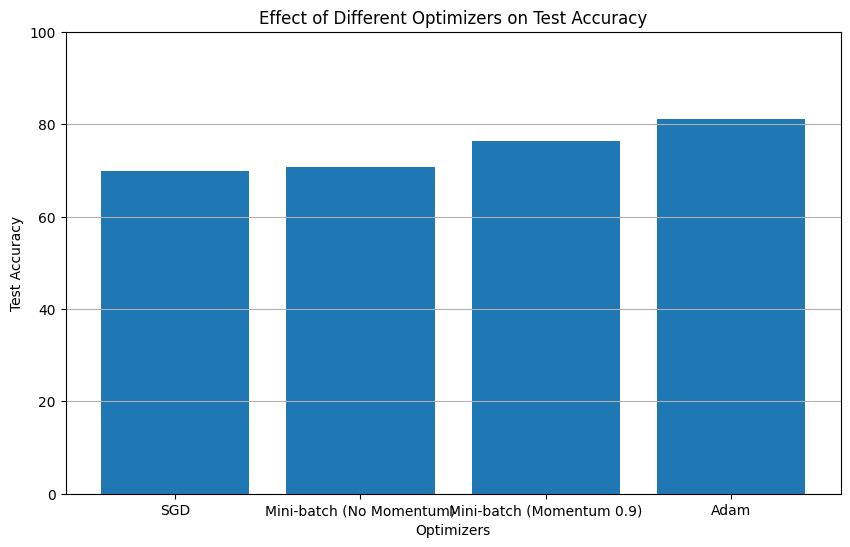

In [20]:
import matplotlib.pyplot as plt
# Plotting evaluation results
plt.figure(figsize=(10, 6))
plt.bar(eval_results.keys(), eval_results.values())
plt.xlabel('Optimizers')
plt.ylabel('Test Accuracy')
plt.title('Effect of Different Optimizers on Test Accuracy')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()

### Plotting Training Accuracy vs Epochs for each Optimizer

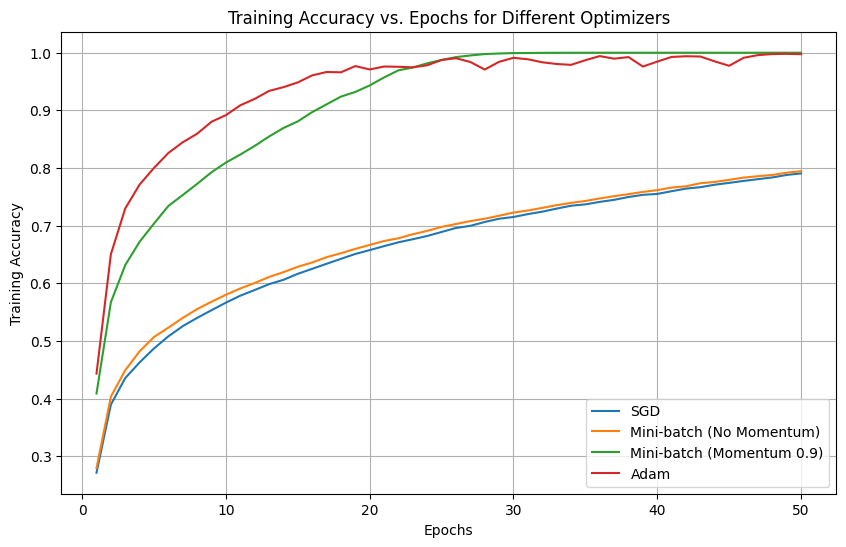

In [21]:
# Plotting training accuracy vs epochs for each optimizer
plt.figure(figsize=(10, 6))
for optimizer_name, history in train_accuracy_histories.items():
    plt.plot(range(1, len(history) + 1), history, label=optimizer_name)

plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.grid(True)
plt.show()

### Determining the Best Optimizer

In [22]:
# Determine the best optimizer
best_optimizer = max(eval_results, key=eval_results.get)
print(f"The best optimizer is: {best_optimizer} with a test accuracy of {eval_results[best_optimizer]:.2f}%")

The best optimizer is: Adam with a test accuracy of 81.06%


## Adam is the Best Optimizer !!

 # Experiment 4: Study the Effect of Network Depth

### Defining CNN network with 4 resnet blocks and 2 FC Layers

In [23]:
class CNNResNet4Level(nn.Module):
    def __init__(self):
        super(CNNResNet4Level, self).__init__()  # Initialize superclass
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # First convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        # Define four ResNet blocks
        self.resnet_block1 = ResNetBlock(32, 64)
        self.resnet_block2 = ResNetBlock(64, 64)
        self.resnet_block3 = ResNetBlock(64, 64)
        self.resnet_block4 = ResNetBlock(64, 64)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Second fully connected layer (output layer)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Convolutional layer followed by ReLU and pooling
        # Pass through each ResNet block
        x = self.resnet_block1(x)
        x = self.resnet_block2(x)
        x = self.resnet_block3(x)
        x = self.resnet_block4(x)
        x = self.pool(x)  # Pooling layer
        x = x.view(-1, 64 * 8 * 8)  # Flatten the output
        x = torch.relu(self.fc1(x))  # Fully connected layer followed by ReLU
        x = self.fc2(x)  # Output layer
        return x


## Defining CNN Network with 3 Resnet Blocks and 4 Fully Connected Layers

In [24]:
class CNNResNet3Level(nn.Module):
    def __init__(self):
        super(CNNResNet3Level, self).__init__()  # Initialize superclass
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # First convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        # Define three ResNet blocks
        self.resnet_block1 = ResNetBlock(32, 64)
        self.resnet_block2 = ResNetBlock(64, 64)
        self.resnet_block3 = ResNetBlock(64, 64)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 64)  # Second fully connected layer
        self.fc3 = nn.Linear(64, 64)  # Third fully connected layer
        self.fc4 = nn.Linear(64, 10)  # Output layer

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Convolutional layer followed by ReLU and pooling
        # Pass through each ResNet block
        x = self.resnet_block1(x)
        x = self.resnet_block2(x)
        x = self.resnet_block3(x)
        x = self.pool(x)  # Pooling layer
        x = x.view(-1, 64 * 8 * 8)  # Flatten the output
        x = torch.relu(self.fc1(x))  # First fully connected layer followed by ReLU
        x = torch.relu(self.fc2(x))  # Second fully connected layer followed by ReLU
        x = torch.relu(self.fc3(x))  # Third fully connected layer followed by ReLU
        x = self.fc4(x)  # Output layer
        return x


## There is an effective increase of 2 layers on top of our original CNN-Resnet Model in the above 2 Models that have been defined
Either 2 FCs added or a Resnet block that has 2 Convolutional Layers were added

## Initializing both the models and defining optimizers

In [25]:
# Initialize models
cnn_resnet_4level = CNNResNet4Level().to(device)  # CNNResNet4Level model moved to device
cnn_resnet_3level = CNNResNet3Level().to(device)  # CNNResNet3Level model moved to device

# Define optimizers
optimizer_resnet_4level = optim.Adam(cnn_resnet_4level.parameters(), lr=0.001)  # Adam optimizer for CNNResNet4Level
optimizer_resnet_3level = optim.Adam(cnn_resnet_3level.parameters(), lr=0.001)  # Adam optimizer for CNNResNet3Level

print(cnn_resnet_4level)  # Print CNNResNet4Level model
print(cnn_resnet_3level)  # Print CNNResNet3Level model

CNNResNet4Level(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resnet_block1): ResNetBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_block2): ResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Training CNN Resnet with 4 Resnet blocks and 2 Fcs

In [26]:
# Train models
print("Training Resnet 4 Level")
train_accuracy_resnet_4level = train_model(cnn_resnet_4level, trainloader, criterion, optimizer_resnet_4level)

Training Resnet 4 Level
Epoch 1, Loss: 1.582699430840356, Accuracy: 44.39%
Epoch 2, Loss: 0.9863045921131056, Accuracy: 64.94%
Epoch 3, Loss: 0.7726298683151906, Accuracy: 72.76%
Epoch 4, Loss: 0.6530546813595052, Accuracy: 77.02%
Epoch 5, Loss: 0.5844596153011128, Accuracy: 79.42%
Epoch 6, Loss: 0.5148119528074654, Accuracy: 81.97%
Epoch 7, Loss: 0.4614355593007438, Accuracy: 83.86%
Epoch 8, Loss: 0.40374273426678714, Accuracy: 85.89%
Epoch 9, Loss: 0.34771863979344464, Accuracy: 87.77%
Epoch 10, Loss: 0.3101028631992486, Accuracy: 89.28%
Epoch 11, Loss: 0.26466925784337275, Accuracy: 90.70%
Epoch 12, Loss: 0.23097816406159985, Accuracy: 91.92%
Epoch 13, Loss: 0.18707036531093169, Accuracy: 93.48%
Epoch 14, Loss: 0.1639515050135705, Accuracy: 94.11%
Epoch 15, Loss: 0.14901008973924482, Accuracy: 94.74%
Epoch 16, Loss: 0.11065913468827399, Accuracy: 96.11%
Epoch 17, Loss: 0.09592340799162583, Accuracy: 96.61%
Epoch 18, Loss: 0.09693762779768024, Accuracy: 96.60%
Epoch 19, Loss: 0.07155

### Training CNN Resnet with 3 Resnet blocks and 4 Fcs

In [27]:
print("Training Resnet 3 Level")
train_accuracy_resnet_3level = train_model(cnn_resnet_3level, trainloader, criterion, optimizer_resnet_3level)

Training Resnet 3 Level
Epoch 1, Loss: 1.417984468596322, Accuracy: 47.39%
Epoch 2, Loss: 0.9334235471122119, Accuracy: 66.75%
Epoch 3, Loss: 0.7502414982537834, Accuracy: 73.66%
Epoch 4, Loss: 0.648315858476016, Accuracy: 77.25%
Epoch 5, Loss: 0.5618453114008417, Accuracy: 80.39%
Epoch 6, Loss: 0.5044902934103596, Accuracy: 82.31%
Epoch 7, Loss: 0.44983118772506714, Accuracy: 84.16%
Epoch 8, Loss: 0.40205544354964273, Accuracy: 86.02%
Epoch 9, Loss: 0.3425227071405674, Accuracy: 88.18%
Epoch 10, Loss: 0.31079837140076016, Accuracy: 89.17%
Epoch 11, Loss: 0.27109040897719716, Accuracy: 90.43%
Epoch 12, Loss: 0.24270750133662808, Accuracy: 91.38%
Epoch 13, Loss: 0.21512127089865354, Accuracy: 92.41%
Epoch 14, Loss: 0.1902640410984049, Accuracy: 93.25%
Epoch 15, Loss: 0.1564850515248824, Accuracy: 94.41%
Epoch 16, Loss: 0.1385759442702544, Accuracy: 95.01%
Epoch 17, Loss: 0.12876829715939808, Accuracy: 95.43%
Epoch 18, Loss: 0.10764972645105148, Accuracy: 96.13%
Epoch 19, Loss: 0.0977833

### Evaluating Models

In [28]:
# Evaluate the models
accuracy_resnet_4level = evaluate_model(cnn_resnet_4level, testloader)
accuracy_resnet_3level = evaluate_model(cnn_resnet_3level, testloader)

# Print results
print("Accuracy of CNN-ResNet with 4-level blocks and 2 FC on the test set:", accuracy_resnet_4level)
print("Accuracy of CNN-ResNet with 3-level blocks and 4 FC on the test set:", accuracy_resnet_3level)
print("Accuracy of CNN-ResNet with 3-level blocks and 2 FC on the test set:", accuracy_resnet)

Accuracy of CNN-ResNet with 4-level blocks and 2 FC on the test set: 84.1
Accuracy of CNN-ResNet with 3-level blocks and 4 FC on the test set: 79.66
Accuracy of CNN-ResNet with 3-level blocks and 2 FC on the test set: 83.44


### Plotting Training Accuracy vs Epochs for each model

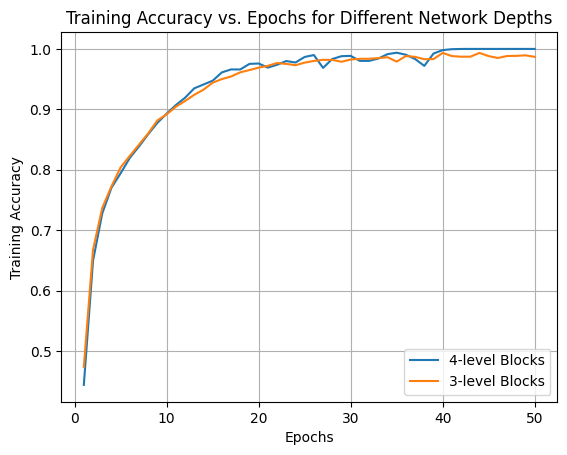

In [29]:
# Plotting training accuracy vs. epochs for each model
plt.plot(range(1, len(train_accuracy_resnet_4level) + 1), train_accuracy_resnet_4level, label='4-level Blocks')
plt.plot(range(1, len(train_accuracy_resnet_3level) + 1), train_accuracy_resnet_3level, label='3-level Blocks')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Epochs for Different Network Depths')
plt.legend()
plt.grid(True)
plt.show()

### Comparing number of parameters in the 3 Resnet Models

In [30]:
# Commenting on the performance and number of parameters
print("Number of parameters in CNN-ResNet with 4-level blocks and 2 FC:", sum(p.numel() for p in cnn_resnet_4level.parameters()))
print("Number of parameters in CNN-ResNet with 3-level blocks and 4 FC:", sum(p.numel() for p in cnn_resnet_3level.parameters()))
print("Number of parameters in CNN-ResNet with 3-level blocks and 2 FC:", sum(p.numel() for p in cnn_resnet.parameters()))

Number of parameters in CNN-ResNet with 4-level blocks and 2 FC: 806282
Number of parameters in CNN-ResNet with 3-level blocks and 4 FC: 744074
Number of parameters in CNN-ResNet with 3-level blocks and 2 FC: 732298


### Comparing Resnet model with 3 blocks and 4 Fcs & Resnet model with 4 blocks and 2 Fcs

In [31]:
if accuracy_resnet_4level > accuracy_resnet_3level:
    print("CNN-ResNet with 4-level blocks performs better on the given problem.")
elif accuracy_resnet_4level < accuracy_resnet_3level:
    print("CNN-ResNet with 3-level blocks performs better on the given problem.")
else:
    print("Both CNN-ResNet models perform equally well on the given problem.")

CNN-ResNet with 4-level blocks performs better on the given problem.


## CNN-Resnet with 4 blocks and 2 Fcs is the Winner amongst the 2 !!

### Comparing Resnet model with 3 blocks and 2 Fcs & Resnet model with 3 blocks and 4 Fcs & Resnet model with 4 blocks and 2 Fcs

In [32]:
if accuracy_resnet_4level > accuracy_resnet_3level:
    if accuracy_resnet_4level > accuracy_resnet:
        print("Among the 3 Models, CNN-ResNet with 4-level blocks and 2 Fcs performs better on the given problem.")
    else:
        print("Among the 3 Models, Original CNN-ResNet performs better on the given problem.")
elif accuracy_resnet_4level < accuracy_resnet_3level:
    if accuracy_resnet_3level > accuracy_resnet:
        print("Among the 3 Models, CNN-ResNet with 3-level blocks and 4 Fcs performs better on the given problem.")
    else:
        print("Among the 3 Models, Original CNN-ResNet performs better on the given problem.")
else:
    if accuracy_resnet_3level > accuracy_resnet:
        print("Among the 3 Models, CNN-ResNet with 3-level blocks & 4 Fcs performs equally well as CNN-ResNet with 4-level blocks & 2 Fcs on the given problem.")
    else:
        print("Among the 3 Models, Original CNN-ResNet model perform equally well on the given problem.")

Among the 3 Models, CNN-ResNet with 4-level blocks and 2 Fcs performs better on the given problem.


## CNN-Resnet with 4 blocks and 2 Fcs is the Winner amongst the 2 !! Therefore increasing conv layers is better 

# Experiment 5: Study the Effect of Different Regularizers

### Defining ResNet block with BatchNorm 

In [33]:
# Define the ResNet block with BatchNorm
class ResNetBlock_BatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock_BatchNorm, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # Define batch normalization layers
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Define activation function
        self.relu = nn.ReLU(inplace=True)
        # Define shortcut connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        # Forward pass through the block
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# Define CNNResNet with BatchNorm
class CNNResNet_BatchNorm(nn.Module):
    def __init__(self):
        super(CNNResNet_BatchNorm, self).__init__()
        # Define initial convolutional layer and pooling layer
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Define ResNet blocks
        self.resnet_block1 = ResNetBlock(32, 64)
        self.resnet_block2 = ResNetBlock(32, 64)
        self.resnet_block3 = ResNetBlock(32, 64)
        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Updated fc1 input size
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Forward pass through the network
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.resnet_block1(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 8 * 8)  # Adjusted view size
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Defining ResNet block with Dropout

In [34]:
# Define the ResNet block with Dropout
class ResNetBlock_Dropout(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock_Dropout, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # Define dropout layers
        self.dropout = nn.Dropout(0.5)
        # Define activation function
        self.relu = nn.ReLU(inplace=True)
        # Define shortcut connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.Dropout(0.5)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        # Forward pass through the block
        residual = x
        out = self.relu(self.dropout(self.conv1(x)))
        out = self.dropout(self.conv2(out))
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# Define CNNResNet with Dropout
class CNNResNet_Dropout(nn.Module):
    def __init__(self):
        super(CNNResNet_Dropout, self).__init__()
        # Define initial convolutional layer and pooling layer
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Define ResNet blocks
        self.resnet_block1 = ResNetBlock_Dropout(32, 64)
        self.resnet_block2 = ResNetBlock_Dropout(32, 64)
        self.resnet_block3 = ResNetBlock_Dropout(32, 64)
        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Updated fc1 input size
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Forward pass through the network
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.resnet_block1(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 8 * 8)  # Adjusted view size - Flattened
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Defining ResNet block with BatchNorm and Dropout

In [35]:
# Define the ResNet block with Batchnorm and Dropout
class ResNetBlock_Dropout_BatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock_Dropout_BatchNorm, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # Define batch normalization layers
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Define dropout layer
        self.dropout = nn.Dropout(0.5)
        # Define activation function
        self.relu = nn.ReLU(inplace=True)
        # Define shortcut connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.Dropout(0.5),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        # Forward pass through the block
        residual = x
        out = self.relu(self.bn1(self.dropout(self.conv1(x))))
        out = self.bn2(self.dropout(self.conv2(out)))
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# Define CNNResNet with Batchnorm and Dropout
class CNNResNet_Dropout_BatchNorm(nn.Module):
    def __init__(self):
        super(CNNResNet_Dropout_BatchNorm, self).__init__()
        # Define initial convolutional layer and pooling layer
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Define ResNet blocks
        self.resnet_block1 = ResNetBlock_Dropout_BatchNorm(32, 64)
        self.resnet_block2 = ResNetBlock_Dropout_BatchNorm(32, 64)
        self.resnet_block3 = ResNetBlock_Dropout_BatchNorm(32, 64)
        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Updated fc1 input size
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Forward pass through the network
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.resnet_block1(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 8 * 8)  # Adjusted view size
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Initializing Models and their Optimizers

In [36]:
# Initialize models
cnn_resnet_batchnorm = CNNResNet_BatchNorm()
cnn_resnet_dropout = CNNResNet_Dropout()
cnn_resnet_dropout_batchnorm = CNNResNet_Dropout_BatchNorm()

cnn_resnet_batchnorm.to(device)
cnn_resnet_dropout.to(device)
cnn_resnet_dropout_batchnorm.to(device)

# Define optimizers
optimizer_cnn_resnet_batchnorm = optim.Adam(cnn_resnet_batchnorm.parameters(), lr=0.001)
optimizer_cnn_resnet_dropout = optim.Adam(cnn_resnet_dropout.parameters(), lr=0.001)
optimizer_cnn_resnet_dropout_batchnorm = optim.Adam(cnn_resnet_dropout_batchnorm.parameters(), lr=0.001)

print(cnn_resnet_batchnorm)
print(cnn_resnet_dropout)
print(cnn_resnet_dropout_batchnorm)

CNNResNet_BatchNorm(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resnet_block1): ResNetBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_block2): ResNetBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

### Defining Training Function which also evaluates model on test data every Epoch

In [37]:
def train_test_model(model, trainloader, criterion, optimizer, testloader, num_epochs=50):
    model.train()
    train_accuracy_history = []  # List to store training accuracy for each epoch
    test_accuracy_history = []   # List to store test accuracy for each epoch
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        # Calculate accuracy for the epoch
        epoch_accuracy = correct_predictions / total_predictions
        train_accuracy_history.append(epoch_accuracy)
        
        # Evaluation phase
        test_accuracy = evaluate_model(model, testloader)
        test_accuracy_history.append(test_accuracy)

        print(f'Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}, Accuracy: {epoch_accuracy:.2%}')

    return test_accuracy_history


### Training Model with  Batch Normalization

In [38]:
# Train the models with different regularizers
print("Training CNN Resnet with Batch Norm")
test_accuracy_bn = train_test_model(cnn_resnet_batchnorm, trainloader, criterion, optimizer_cnn_resnet_batchnorm, testloader)

Training CNN Resnet with Batch Norm
Epoch 1, Loss: 1.3356595094106636, Accuracy: 51.81%
Epoch 2, Loss: 0.9422734398014692, Accuracy: 66.67%
Epoch 3, Loss: 0.7871792726978963, Accuracy: 72.22%
Epoch 4, Loss: 0.6847812648938627, Accuracy: 75.96%
Epoch 5, Loss: 0.5934651735789922, Accuracy: 79.19%
Epoch 6, Loss: 0.5078055426782492, Accuracy: 82.34%
Epoch 7, Loss: 0.4433463668944884, Accuracy: 84.60%
Epoch 8, Loss: 0.36855745581643923, Accuracy: 86.92%
Epoch 9, Loss: 0.3068259683798771, Accuracy: 89.34%
Epoch 10, Loss: 0.2547240448849542, Accuracy: 91.03%
Epoch 11, Loss: 0.20124912649697188, Accuracy: 92.96%
Epoch 12, Loss: 0.16541569809220275, Accuracy: 94.23%
Epoch 13, Loss: 0.12930488324134934, Accuracy: 95.53%
Epoch 14, Loss: 0.10502571030995067, Accuracy: 96.42%
Epoch 15, Loss: 0.10436521711930329, Accuracy: 96.32%
Epoch 16, Loss: 0.10979535354643452, Accuracy: 96.11%
Epoch 17, Loss: 0.07713580593390733, Accuracy: 97.31%
Epoch 18, Loss: 0.07386460216069708, Accuracy: 97.36%
Epoch 19, 

### Training Model with Dropout

In [39]:
print("Training CNN Resnet with Dropout")
test_accuracy_dropout = train_test_model(cnn_resnet_dropout, trainloader, criterion, optimizer_cnn_resnet_dropout, testloader)

Training CNN Resnet with Dropout
Epoch 1, Loss: 1.4716575644454177, Accuracy: 47.40%
Epoch 2, Loss: 1.0704431938273566, Accuracy: 62.39%
Epoch 3, Loss: 0.8832807413169316, Accuracy: 69.18%
Epoch 4, Loss: 0.7722450969170551, Accuracy: 73.09%
Epoch 5, Loss: 0.6718563750690344, Accuracy: 76.68%
Epoch 6, Loss: 0.5942377990909985, Accuracy: 79.56%
Epoch 7, Loss: 0.5134556433376001, Accuracy: 82.30%
Epoch 8, Loss: 0.4501600124093951, Accuracy: 84.37%
Epoch 9, Loss: 0.37619348896705374, Accuracy: 86.98%
Epoch 10, Loss: 0.3012049776711026, Accuracy: 89.62%
Epoch 11, Loss: 0.24745189284487645, Accuracy: 91.64%
Epoch 12, Loss: 0.1919419236329137, Accuracy: 93.59%
Epoch 13, Loss: 0.14722406951596542, Accuracy: 95.11%
Epoch 14, Loss: 0.1274622043556705, Accuracy: 95.79%
Epoch 15, Loss: 0.09170363636269253, Accuracy: 96.99%
Epoch 16, Loss: 0.07346216279405113, Accuracy: 97.66%
Epoch 17, Loss: 0.06012013566927338, Accuracy: 98.11%
Epoch 18, Loss: 0.07892288631588525, Accuracy: 97.25%
Epoch 19, Loss:

### Training Model with  Batch Normalization and Dropout

In [40]:
print("Training CNN Resnet with Batch Norm and Dropout")
test_accuracy_dropout_bn = train_test_model(cnn_resnet_dropout_batchnorm, trainloader, criterion, optimizer_cnn_resnet_dropout_batchnorm, testloader)

Training CNN Resnet with Batch Norm and Dropout
Epoch 1, Loss: 1.73270326427051, Accuracy: 38.93%
Epoch 2, Loss: 1.2377028301054118, Accuracy: 55.78%
Epoch 3, Loss: 1.0362947227395312, Accuracy: 63.40%
Epoch 4, Loss: 0.9074722896425091, Accuracy: 68.25%
Epoch 5, Loss: 0.8142508891772251, Accuracy: 71.48%
Epoch 6, Loss: 0.7442261576652527, Accuracy: 73.97%
Epoch 7, Loss: 0.6910008417100323, Accuracy: 75.86%
Epoch 8, Loss: 0.6434815227985382, Accuracy: 77.58%
Epoch 9, Loss: 0.5868743141086734, Accuracy: 79.41%
Epoch 10, Loss: 0.5425001303760373, Accuracy: 81.19%
Epoch 11, Loss: 0.502334398274519, Accuracy: 82.54%
Epoch 12, Loss: 0.4642230281416251, Accuracy: 83.79%
Epoch 13, Loss: 0.42955197834846925, Accuracy: 85.00%
Epoch 14, Loss: 0.3922140330684428, Accuracy: 86.40%
Epoch 15, Loss: 0.3621311705483466, Accuracy: 87.28%
Epoch 16, Loss: 0.3170371228943066, Accuracy: 88.93%
Epoch 17, Loss: 0.29290681263926077, Accuracy: 89.70%
Epoch 18, Loss: 0.2659926300450247, Accuracy: 90.76%
Epoch 19

### Plot testing accuracy vs epochs for the three cases

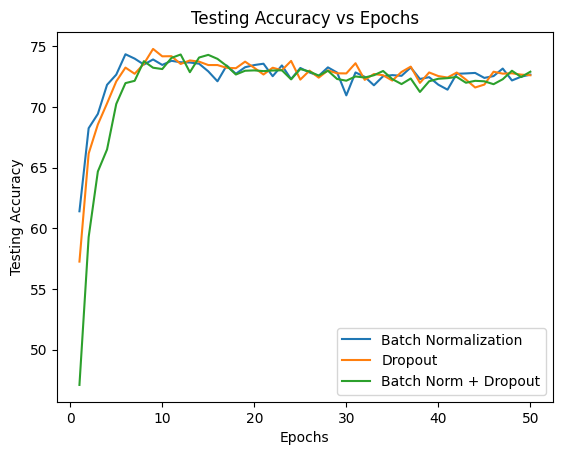

In [41]:
# Plot testing accuracy vs epochs for the three cases
plt.plot(range(1, len(test_accuracy_bn) + 1), test_accuracy_bn, label='Batch Normalization')
plt.plot(range(1, len(test_accuracy_dropout) + 1), test_accuracy_dropout, label='Dropout')
plt.plot(range(1, len(test_accuracy_dropout_bn) + 1), test_accuracy_dropout_bn, label='Batch Norm + Dropout')
plt.title('Testing Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')
plt.legend()
plt.show()

### Comparing Performance and determining Best choice

In [42]:
# Compare the performance and determine the best choice
print(f"Accuracy of BatchNorm is: {test_accuracy_bn[-1]}")
print(f"Accuracy of Dropout is: {test_accuracy_dropout[-1]}")
print(f"Accuracy of BatchNorm and Dropout is: {test_accuracy_dropout_bn[-1]}")
best_accuracy = max(test_accuracy_bn[-1], test_accuracy_dropout[-1], test_accuracy_dropout_bn[-1])
best_choice = None
if best_accuracy == test_accuracy_bn[-1]:
    best_choice = 'Batch Normalization'
elif best_accuracy == test_accuracy_dropout[-1]:
    best_choice = 'Dropout'
else:
    best_choice = 'Batch Norm + Dropout'

print(f"The best choice among the three regularizers is: {best_choice}")

Accuracy of BatchNorm is: 72.67
Accuracy of Dropout is: 72.62
Accuracy of BatchNorm and Dropout is: 72.91
The best choice among the three regularizers is: Batch Norm + Dropout
